In [ ]:
pip install pandas numpy xgboost requests yfinance scikit-learn cvxpy matplotlib

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import requests
import yfinance as yf
from sklearn.cluster import KMeans
import cvxpy as cp
import matplotlib.pyplot as plt

In [ ]:
# --- Configuration ---

tickers = ["AAPL", "MSFT", "GOOGL"]               # Small set of stocks for demo
start_date = "2023-01-01"
end_date = "2024-01-01"
huggingface_api_key = "HF_KEY"  # Replace with your key

In [6]:
# --- Helper Functions ---

def fetch_stock_data(tickers, start, end):
    """Fetch historical stock data from Yahoo Finance."""
    data = yf.download(tickers, start=start, end=end, progress=False)
    # Check if 'Adj Close' column exists, otherwise use 'Close'
    if 'Adj Close' in data.columns:
        data = data['Adj Close']
    else:
        data = data['Close']  # Use 'Close' if 'Adj Close' is missing
    returns = data.pct_change().dropna()
    return data, returns

def mock_earnings_transcript(ticker):
    """Mock earnings call transcript for demo purposes."""
    transcripts = {
        "AAPL": "Earnings were strong this quarter, exceeding expectations.",
        "MSFT": "We saw solid growth, though cloud margins are under pressure.",
        "GOOGL": "Revenue beat forecasts, but ad spend remains volatile."
    }
    return transcripts.get(ticker, "No transcript available.")

In [7]:
# --- 1. Data Collection & Preprocessing ---

print("Fetching stock data...")
prices, returns = fetch_stock_data(tickers, start_date, end_date)

# Fundamental Data (mocked for simplicity)
fundamental_data = pd.DataFrame({
    "PE_Ratio": [20, 25, 30],            # Mock P/E ratios
    "Revenue_Growth": [0.1, 0.15, 0.2],  # Mock revenue growth
    "Target_Return": [0.05, 0.06, 0.07]  # Mock expected returns for training
}, index=tickers)

# Factor Data (computed from prices)
factor_data = pd.DataFrame({
    "Momentum": prices.pct_change(50).iloc[-1],  # 50-day momentum
    "Volatility": returns.std()                  # Historical volatility
}, index=tickers)

Fetching stock data...


In [8]:
# --- 2. Fundamental Analysis Model ---

# XGBoost (Local)
print("Training XGBoost model...")
dtrain = xgb.DMatrix(fundamental_data[["PE_Ratio", "Revenue_Growth"]], label=fundamental_data["Target_Return"])
params = {"max_depth": 3, "eta": 0.1, "objective": "reg:squarederror"}
xgboost_model = xgb.train(params, dtrain, num_boost_round=10)
xgboost_scores = xgboost_model.predict(dtrain)

# BERT via Hugging Face API (NLP for earnings sentiment)
print("Fetching sentiment from Hugging Face API...")
api_url = "https://api-inference.huggingface.co/models/ProsusAI/finbert"
headers = {"Authorization": f"Bearer {huggingface_api_key}"}
bert_sentiments = []
for ticker in tickers:
    transcript = mock_earnings_transcript(ticker)
    response = requests.post(api_url, headers=headers, json={"inputs": transcript})
    if response.status_code == 200:
        sentiment = response.json()[0]
        positive_score = next(item["score"] for item in sentiment if item["label"] == "positive")
        bert_sentiments.append(positive_score)
    else:
        print(f"API error for {ticker}: {response.status_code}")
        bert_sentiments.append(0.5)  # Fallback neutral score
bert_sentiments = np.array(bert_sentiments)

Training XGBoost model...
Fetching sentiment from Hugging Face API...
API error for AAPL: 503
API error for MSFT: 503
API error for GOOGL: 503


In [9]:
# --- 3. Factor-Based Model ---

# K-Means (Local)
print("Clustering stocks with K-Means...")
kmeans = KMeans(n_clusters=2, random_state=42).fit(factor_data)
clusters = kmeans.labels_

# Mock LightGBM (simplified ranking based on momentum)
print("Mocking LightGBM factor scores...")
lightgbm_scores = factor_data["Momentum"].rank(ascending=True).values / len(tickers)  # Normalized rank

Clustering stocks with K-Means...
Mocking LightGBM factor scores...


In [10]:
# --- 4. Hybrid Decision Engine ---

# Weighted Ensemble
print("Combining scores in Hybrid Decision Engine...")
initial_weights = [0.4, 0.3, 0.3]  # XGBoost, BERT, LightGBM
final_scores = (initial_weights[0] * xgboost_scores + initial_weights[1] * bert_sentiments + initial_weights[2] * lightgbm_scores)

# Simple Multi-Armed Bandit (Thompson Sampling) for weight adjustment
print("Simulating Multi-Armed Bandit for weight adjustment...")
weight_options = [
    [0.4, 0.3, 0.3],  # Balanced
    [0.5, 0.3, 0.2],  # Fundamental-heavy
    [0.3, 0.2, 0.5]   # Factor-heavy
]
successes = [1, 1, 1]  # Mock initial successes
failures = [1, 1, 1]   # Mock initial failures
for _ in range(5):     # Simulate 5 iterations
    # Sample from Beta distribution for each arm
    samples = [np.random.beta(s + 1, f + 1) for s, f in zip(successes, failures)]
    chosen_arm = np.argmax(samples)
    chosen_weights = weight_options[chosen_arm]
    # Mock performance (higher final score = success)
    new_scores = (chosen_weights[0] * xgboost_scores + chosen_weights[1] * bert_sentiments + chosen_weights[2] * lightgbm_scores)
    if new_scores.mean() > final_scores.mean():
        successes[chosen_arm] += 1
    else:
        failures[chosen_arm] += 1
    final_scores = new_scores
print(f"Final weights: {chosen_weights}")

Combining scores in Hybrid Decision Engine...
Simulating Multi-Armed Bandit for weight adjustment...
Final weights: [0.5, 0.3, 0.2]


In [11]:
# --- 5. Portfolio Optimization ---

print("Optimizing portfolio...")
expected_returns = final_scores
cov_matrix = returns.cov().values  # Covariance matrix from historical returns
n = len(tickers)
w = cp.Variable(n)  # Portfolio weights
objective = cp.Maximize(expected_returns @ w - 0.1 * cp.quad_form(w, cov_matrix))  # Risk-adjusted return
constraints = [cp.sum(w) == 1, w >= 0]  # Sum to 1, no shorting
problem = cp.Problem(objective, constraints)
problem.solve()
portfolio_weights = w.value

Optimizing portfolio...



Prototype Results:
  Ticker  XGBoost_Score  BERT_Sentiment  LightGBM_Score  Final_Score  \
0   AAPL          0.056             0.5           0.667        0.311   
1   MSFT          0.060             0.5           1.000        0.380   
2  GOOGL          0.064             0.5           0.333        0.249   

   Portfolio_Weight  Cluster  
0              -0.0        0  
1               1.0        0  
2              -0.0        1  


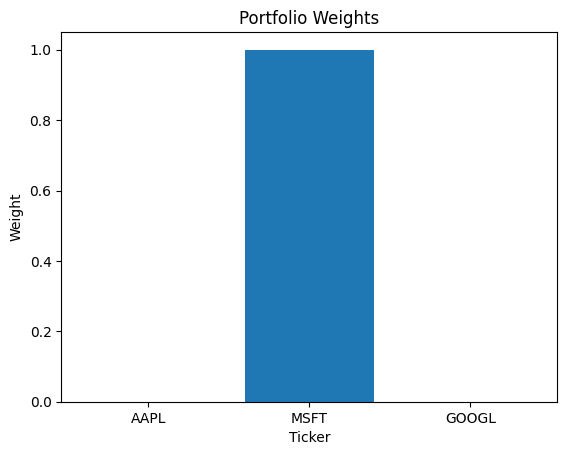

In [12]:
# --- 6. Results ---

results = pd.DataFrame({
    "Ticker": tickers,
    "XGBoost_Score": xgboost_scores,
    "BERT_Sentiment": bert_sentiments,
    "LightGBM_Score": lightgbm_scores,
    "Final_Score": final_scores,
    "Portfolio_Weight": portfolio_weights,
    "Cluster": clusters
})
print("\nPrototype Results:")
print(results.round(3))

# Visualize portfolio weights
plt.bar(tickers, portfolio_weights)
plt.title("Portfolio Weights")
plt.xlabel("Ticker")
plt.ylabel("Weight")
plt.show()


Simulating 365-day portfolio performance...


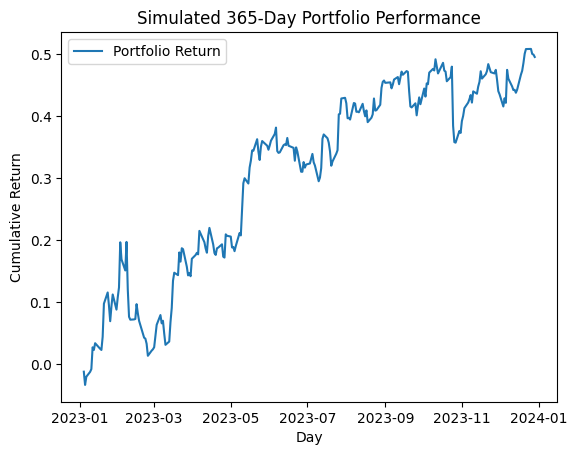

In [15]:
# --- 7. Mock Trading Simulation ---

print("\nSimulating 365-day portfolio performance...")
portfolio_returns = (returns.iloc[-365:] @ portfolio_weights).cumsum()
plt.plot(portfolio_returns, label="Portfolio Return")
plt.title("Simulated 365-Day Portfolio Performance")
plt.xlabel("Day")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()